In [68]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from helpers import get_dataset_range

In [2]:
# NOAA classifies 2015-16 and 2010-11 as strong or very strong events
# of el nino and la nina, respectively
nino_data = get_dataset_range(2015, 2016)
nina_data = get_dataset_range(2010, 2011)

# all non-strong classified data
interval1_data = get_dataset_range(2008, 2009)
interval2_data = get_dataset_range(2012, 2014)
interval3_data = get_dataset_range(2017, 2022)

In [8]:
# split relevant states into climate regions as defined:
# https://www.ncei.noaa.gov/access/monitoring/reference-maps/us-climate-regions
regions = {
    'northwest': ['Washington', 'Oregon', 'Idaho'],
    'west': ['California', 'Nevada'],
    'southwest': ['Utah', 'New Mexico', 'Wyoming', 'Arizona'],
    'south': ['Texas', 'Oklahoma', 'Louisiana', 'Arkansas', 'Mississippi'],
    'southeast': ['Alabama', 'Georgia', 'Florida', 'North Carolina', 'South Carolina', 'Virginia'],
    'midwest': ['Minnesota', 'Wisconsin', 'Michigan', 'Iowa'],
    'ohio': ['Ohio', 'Missouri', 'Tennessee', 'Kentucky', 'West Virginia', 'Indiana', 'Illinois']
    # exclude northeast
}
# too lazy to caps manually
for region in regions.keys():
    regions[region] = [r.upper() for r in regions[region]]

def count_events(dataset_list):
    # to count events in each region
    region_counts = { 'northwest': 0, 'west': 0, 'southwest': 0, 'south': 0, 
                    'southeast': 0, 'midwest': 0, 'ohio': 0 }
    for x in dataset_list.values():
        for region in regions.keys():
            relevant = x[np.isin(x['STATE'], regions[region])]
            region_counts[region] += len(relevant)
    return region_counts

def single_count_events(dataset):
    region_counts = { 'northwest': 0, 'west': 0, 'southwest': 0, 'south': 0, 
                    'southeast': 0, 'midwest': 0, 'ohio': 0 }
    for region in regions.keys():
        relevant = dataset[np.isin(dataset['STATE'], regions[region])]
        region_counts[region] += len(relevant)
    return region_counts
        

In [5]:
nino_counts = count_events(nino_data)
print(nino_counts)
nina_counts = count_events(nina_data)
print(nina_counts)

{'northwest': 2209, 'west': 2914, 'southwest': 5685, 'south': 18073, 'southeast': 16543, 'midwest': 10732, 'ohio': 21179}
{'northwest': 1935, 'west': 2108, 'southwest': 5689, 'south': 22196, 'southeast': 22050, 'midwest': 13834, 'ohio': 28981}


In [6]:
interval1_counts = count_events(interval1_data)
interval2_counts = count_events(interval2_data)
interval3_counts = count_events(interval3_data)
interval_num_yrs = 2+3+6
interval_counts = { 'northwest': 0, 'west': 0, 'southwest': 0, 'south': 0, 
                    'southeast': 0, 'midwest': 0, 'ohio': 0 }
for region in interval_counts.keys():
    year_weight = 2 / interval_num_yrs
    interval_counts[region] = round((interval1_counts[region] + interval2_counts[region] + interval3_counts[region]) * year_weight, 2)

print(interval_counts)

{'northwest': 2363.45, 'west': 4048.0, 'southwest': 6425.82, 'south': 19387.09, 'southeast': 16794.0, 'midwest': 12594.36, 'ohio': 21577.09}


In [11]:
all_years_data = get_dataset_range(2008, 2022)
year_counts = {}
formatted_data = interval_counts = { 'northwest': [], 'west': [], 'southwest': [], 'south': [], 
                    'southeast': [], 'midwest': [], 'ohio': [] }
for year in all_years_data.keys():
    counts = single_count_events(all_years_data[year])
    for region in regions.keys():
        formatted_data[region].append(counts[region])

formatted_df = pd.DataFrame(formatted_data, index = [year for year in all_years_data.keys()])
formatted_df

,northwest,west,southwest,south,southeast,midwest,ohio
2008,1217,1446,1944,10923,10651,9157,13410
2009,916,1062,1835,11186,8807,4936,10230
2010,1020,1110,2765,8052,9145,7370,13107
2011,915,998,2924,14144,12905,6464,15874
2012,1286,1130,3028,10452,10325,6209,12613
2013,832,947,3828,10069,6512,6494,10133
2014,1224,1426,3614,8916,7402,6869,10076
2015,1292,1397,2775,10193,7834,5035,11550
2016,917,1517,2910,7880,8709,5697,9629
2017,1464,2161,3162,8620,7815,5230,9826


In [25]:
# take the mean for each region over the years to establish a "baseline"
baseline = { 'northwest': 0, 'west': 0, 'southwest': 0, 'south': 0, 
                    'southeast': 0, 'midwest': 0, 'ohio': 0 }
for region in baseline.keys():
    baseline[region] = int(round(formatted_df[region].mean(), 0))
baseline

{'northwest': 1143,
 'west': 1819,
 'southwest': 3114,
 'south': 9793,
 'southeast': 8731,
 'midwest': 6256,
 'ohio': 11256}

In [69]:
# compare the very strong event years to that baseline to determine if there is a significant difference
# year categorizations found at: https://ggweather.com/enso/oni.htm
# using data from the same organization that put together the storms dataset
v_strong_nino_yr_counts = formatted_df.loc[2015, :]
strong_nina_yr_counts = formatted_df.loc[2011, :]
neither_yr_counts = formatted_df.loc[2013, :]

idx = 0
names = [x for x in baseline.keys()]
while neither_yr_counts.sum() < v_strong_nino_yr_counts.sum():
    neither_yr_counts[names[idx]] += 1
    if idx == len(names) - 1:
        idx = 0
    else:
        idx += 1
    
# TODO: instead to chi square that uses baseline with even distribution across areas
critical_value = stats.chi2.ppf(q = 0.95, df = len(names)-1)
print(critical_value)
stats.chisquare(v_strong_nino_yr_counts, neither_yr_counts)

12.591587243743977


Power_divergenceResult(statistic=1266.9089266896774, pvalue=1.577589581560894e-270)

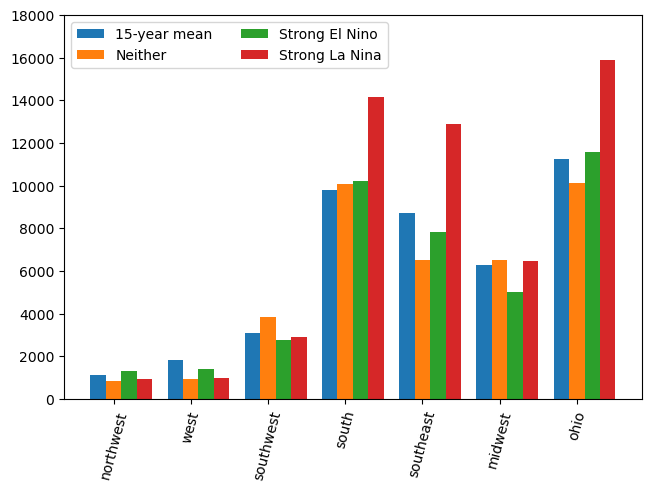

In [63]:
labels = ["15-year mean", "Neither", "Strong El Nino", "Strong La Nina"]
sets = [baseline.values(), neither_yr_counts, v_strong_nino_yr_counts, strong_nina_yr_counts]
regions = tuple([x for x in baseline.keys()])
counts = {}
for i in range(len(labels)):
    counts[labels[i]] = tuple([y for y in sets[i]])

x_ax = np.arange(len(regions))
width = 0.2
mult = 0

fig, ax = plt.subplots(layout="constrained")
for set_label, region_counts in counts.items():
    offset = width * mult
    rects = ax.bar(x_ax + offset, region_counts, width, label=set_label)
    mult += 1

ax.set_xticks(x_ax + width, regions)
plt.xticks(rotation=75)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 18000)
plt.show()

In [80]:
# data again from: https://ggweather.com/enso/oni.htm
oni_ratings = {
    "2008-2009": "WL", "2009-2010": "ME", "2010-2011": "SL", "2011-2012": "ML",
    "2012-2013": "", "2013-2014": "", "2014-2015": "WE", "2015-2016": "VSE",
    "2016-2017": "WL", "2017-2018": "WL", "2018-2019": "WE",  "2019-2020": "",
    "2020-2021": "ML", "2021-2022": "ML" 
}
# translate strength of weather pattern to discreet values
label_to_val_dict = {
    "VSE": 4, "SE": 3, "ME": 2, "WE": 1,
    "": 0, "WL": -1, "ML": -2, "SL": -3
}
# apply translation to each year pairing, then average, to get value per year
# instead of per season
year_ratings = []
year_ratings.append(label_to_val_dict[oni_ratings["2008-2009"]]) # first year
for i in range(2008, 2021):
    key = str(i) + "-" + str(i+1)
    key2 = str(i+1) + "-" + str(i+2)
    val = label_to_val_dict[oni_ratings[key]] + label_to_val_dict[oni_ratings[key2]] / 2
    year_ratings.append(val)
year_ratings.append(label_to_val_dict[oni_ratings["2021-2022"]]) # last year

# even with absolute value, too few entries per rating to perform ANOVA
# could integrate full 70ish year dataset, but not enough time;
# conclusion: ANOVA not very applicable for this task
# other analyses ruled out because question doesn't fit their application(s)
# abs_ratings = np.absolute(year_ratings)
# pd.unique(abs_ratings), pd.unique(year_ratings)

formatted_df["ONI_rating"] = year_ratings
formatted_df["ONI_rating_abs"] = abs_ratings
formatted_df.head()

,northwest,west,southwest,south,southeast,midwest,ohio,ONI_rating,ONI_rating_abs
2018,996,2110,3916,8148,9129,6660,10535,-0.5,0.5
2019,1287,3087,3150,9301,7885,7042,11639,1.0,1.0
2020,1295,2138,2883,8828,9091,4967,9395,-1.0,1.0
2021,1162,3270,4093,8878,6623,5366,9089,-3.0,3.0
2022,1320,3487,3889,11308,8127,6339,11728,-2.0,2.0


In [85]:
def compile_region_counts_per_rating(should_use_abs):
    relevant_col = ''
    if should_use_abs:
        relevant_col = "ONI_rating_abs"
    else:
        relevant_col = "ONI_rating"
    grouped = formatted_df.groupby([relevant_col]).mean()
    return grouped
    
# attempted here to instead use ONI_rating as a scale,
# and try to correlate it with storm frequency in different regions
# tried with nina/nino treated as opposite ends of a scale and
# just the strength of the year's nino/nina
with_abs = compile_region_counts_per_rating(True)
no_abs = compile_region_counts_per_rating(False)
with_abs.head()

,northwest,west,southwest,south,southeast,midwest,ohio,ONI_rating
ONI_rating_abs,,,,,,,,
0.0,964.500000,1094.500000,2921.500000,10717.5,7749.500000,5805.000000,10271.500000,0.000000
0.5,1080.000000,1548.666667,3431.666667,8372.0,8558.666667,6966.333333,11239.333333,0.166667
1.0,1266.333333,2223.666667,2659.000000,9684.0,9209.000000,7055.333333,11481.333333,-0.333333
1.5,1464.000000,2161.000000,3162.000000,8620.0,7815.000000,5230.000000,9826.000000,-1.500000
2.0,1303.000000,2308.500000,3458.500000,10880.0,9226.000000,6274.000000,12170.500000,-2.000000


In [108]:
region_corr = { 'northwest': 0, 'west': 0, 'southwest': 0, 'south': 0, 
                    'southeast': 0, 'midwest': 0, 'ohio': 0 }
for region in region_corr.keys():
    region_corr[region] = round(stats.pearsonr(no_abs.index, no_abs[region])[0],2)

region_corr_abs = { 'northwest': 0, 'west': 0, 'southwest': 0, 'south': 0, 
                    'southeast': 0, 'midwest': 0, 'ohio': 0 }
for region in region_corr_abs.keys():
    region_corr_abs[region] = round(stats.pearsonr(with_abs.index, with_abs[region])[0],2)

# resulting correlation values for each region for both attempted methods;
# values are unconvincing to say the least
print(region_corr)
print(region_corr_abs)

{'northwest': -0.04, 'west': -0.21, 'southwest': -0.36, 'south': -0.51, 'southeast': -0.4, 'midwest': -0.14, 'ohio': -0.37}
{'northwest': -0.26, 'west': -0.06, 'southwest': -0.01, 'south': 0.33, 'southeast': 0.51, 'midwest': -0.27, 'ohio': 0.41}
